# S-2 image processing for NDVI retrieval from GEE
This code is a semi-automatic routine for the download of NDVI values from Sentinel-2 via the Google Earth Engine API. The downloaded data represent the mean value of NDVI over an area of interest (AoI). The shape of the AoI must be provided manually into the code as a Java polygon or similar object.


- The full timeseries of data is downloaded (from april 2017 to today).
- All the images are reprojected with respect to the first one of the collection, that is the same as performing coregistration of all images.
- A threshold-based mask for cloud covering is applied to the image such that any pixels with a probability value less than or equal to the value of the threshold will be kept, while all other pixels will be removed. The updated image with the applied mask is then returned. The threshold is user-defined by input.
- The database of NDVI values is resampled to daily frequency and linearly interpolated.

**Output**

The output database has columns:
- Date: timestamp of date and time of passage rounded at day.
- NDVI: NDVI values, [dimensionless]. NDVI has range [-1,1]: negative values are related to clouds or water, positive small values (near 0) to bare soil, higher positive values to healthy vegetation.
- Geometry: name of AoI.

---
**Dependencies** 

This code requires the installation of the Earth Engine API, `ee`. You can find more info on the installation procedure here: [Python installation of GEE](https://developers.google.com/earth-engine/guides/python_install). \
This code runs on browser-based notebooks only (Google Colaboratory, Jupyter Notebooks, etc...). \
Be aware that you won't need to install the Google Cloud APK to run the code.

The full dependencies required are provided in the file of the environment google, `google.yml`. To install the virtual environment by using conda, run the lines below in the terminal after having activated `conda`.

```python
conda env create -f environment.yml # install environment from file environment.yml
conda activate <myenv> # activate environment with name provided by header of .yml file
conda info --envs # to check if everything worked fine
```
If you don't use `conda`, manually install the dependencies listed in the environment file by using `pip`.

---

In [71]:
from funcs_gee import *

In [72]:
# Trigger the authentication flow.
ee.Authenticate()
 
# Initialize the library.
ee.Initialize()

AttributeError: module 'ee' has no attribute 'Authenticate'

In [2]:
print('Define area of interest. \nIf you have a GeoJSON file, copy paste.\n'+
      'If you have a KML, export to GeoJSON (plenty of free tools online).')

geoJSON = {
"type": "FeatureCollection",
"name": "merged",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "Name": "Budrio_campo_safe_half", "description": None, "tessellate": 1 }, "geometry": { "type": "Polygon", "coordinates": [ [ [ 11.53262979564736, 44.570842547510622 ], [ 11.532328100248961, 44.570445732016537 ], [ 11.53264162483709, 44.570339694294631 ], [ 11.532950828277439, 44.570738040751841 ] ] ] } } ] }

nfeatures = len(geoJSON['features'])
coords_geojson = [geoJSON['features'][i]['geometry']['coordinates'] for i in range(nfeatures)]
# aoi = ee.Geometry.MultiPolygon(coords_geojson)

Define area of interest. 
If you have a GeoJSON file, copy paste.
If you have a KML, export to GeoJSON (plenty of free tools online).


In [29]:
np.diff(lon)

array([3.01695398e-04, 1.18291897e-05, 3.09203440e-04])

In [58]:
# meters = cos(degree latitude) * (1852/60) * arc-seconds
res_m=10
coords_clean=coords[0][0]
lon=np.unique([coords_clean[i][0] for i in range(len(coords_clean))])
lat=np.unique([coords_clean[i][1] for i in range(len(coords_clean))])
mean_lat=np.mean(lat)
res_degs=res_m/(np.cos(np.deg2rad(mean_lat))*1852/60)/3600 #resolution in degrees

lons_1d=np.arange(min(lon), max(lon), res_arcs)
lats_1d=np.arange(min(lat), max(lat), res_arcs)

In [65]:
lons_2d, lats_2d = np.meshgrid(lons_1d, lats_1d)

In [61]:
grid_points_list=[[lon, lat] for lat in lats_1d for lon in lons_1d]

In [62]:
grid_points_list[0]

[11.53232810024896, 44.57033969429463]

In [63]:
grid_areas_list=[]
for p in grid_points_list:
    grid_areas_list.append([p[0]-res_degs, p[1]-res_degs, p[0]+res_degs, p[1]+res_degs])

In [ ]:
pixel=ee.Geometry.Rectangle(grid_area_list[0]) 

In [20]:
import numpy as np
lon, lat = np.meshgrid(lon, lat)

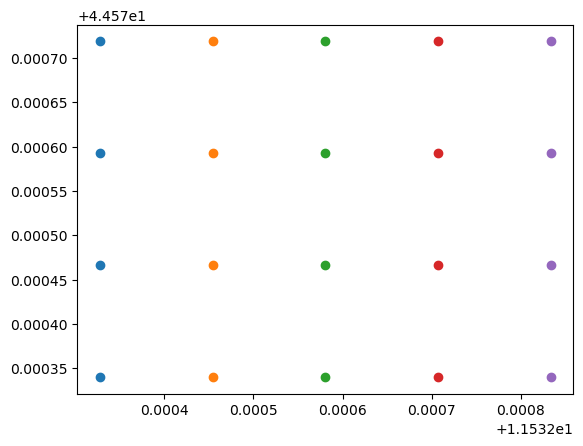

In [47]:
import matplotlib.pyplot as plt
plt.plot(xv, yv, marker='o', linestyle='none')

In [1]:



geometry_title = input('Please provide a title for AoI geometry. (Default: Budrio_half-right)')
if not geometry_title: geometry_title='Budrio_half-right'

Define area of interest. 
If you have a GeoJSON file, copy paste.
If you have a KML, export to GeoJSON (plenty of free tools online).


NameError: name 'ee' is not defined

In [4]:
# Filters definition
sp17 = ee.Filter.date('2017-04-04', '2017-05-22')
su17 = ee.Filter.date('2017-05-22', '2017-09-15')
au17 = ee.Filter.date('2017-09-15', '2017-11-02')
tot17 = ee.Filter.date('2017-01-01', '2017-12-31')

# Get collection of images and filter
s2 = (ee.ImageCollection('COPERNICUS/S2_SR')
        .filterBounds(aoi)
        #.filter(tot17)
        #.filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE',70))
        .select(['B8', 'B4'])
        .sort('system:time_start'))
clouds = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')
        .filterBounds(aoi)
        #.filter(tot17)
        .sort('system:time_start'))
s2 = s2.combine(clouds)

# acq_times = img.aggregate_array('system:time_start').getInfo()
# len([time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times])

# To get all bands and infos of img collection, use
# img.getInfo()

In [5]:
# Reprojection of images
# This action is equivalent to performing coregistration of the images
# to ensure that the coordinates are coherent in the whole collection

proj=s2.first().projection();
scale_mod=ee.Number(proj.nominalScale()).getInfo()
trans_mod=proj.getInfo()['transform'];
crs_mod=proj.getInfo()['crs'];

s2 = s2.map(lambda image: image.reproject(crs_mod,trans_mod))

In [6]:
# Extract data

def maskS2clouds(image):
    qa = image.select('QA60') # 60 m spat res TO0 BIG!!!
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(
        qa.bitwiseAnd(cirrusBitMask).eq(0))
    return image.updateMask(mask) \
                .select("B.*") \
                .copyProperties(image, ["system:time_start"])

def maskCloudPerc(image):
    global thr
    return image.updateMask(image.select('probability').lte(thr))

def addNDVI(image:ee.Image):
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    return image.addBands(ndvi)

def extract_data(image:ee.Image):
    """Ausiliary function to extract data from an Image
    
    Optimal implementation is to map this function
    on a whole ImageCollection via .map() and insert the
    return into a ee.FeatureCollection.
    
    Return
    ------
    ee.Feature
    
    """
    
    ndvi=image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    image=image.addBands(ndvi)
    
    mean = image.reduceRegion(**{ 
        'reducer': ee.Reducer.mean(),
        'geometry': aoi,
    })
        
    properties = {
        'Date': image.get('system:time_start'), # only way to get a timestr is an external operation
        'Geometry': geometry_title,
        'NDVI': mean.get('NDVI'),
    }
    return ee.Feature(None, properties)

In [21]:
# Clouds filtering
thr = 100-int(input('Please provide threshold for cloud masking [number, int]. Ex. \'50\' corresponds to filtering out all images that have 50% or more of pixels that are flagged as covered by clouds.'))
s2_filt = s2.map(maskCloudPerc)

# Add NDVI and extract data
data = ee.FeatureCollection(s2_filt.map(extract_data))
data_out = data.getInfo()
data_out_to_df = [e.get('properties') for e in data_out.get('features')]
print('\nCheck data extraction: if something is printed below and has reasonable values, everything is ok (note: date is in a Matlab-like numeric, weird format, don\'t worry.)'); data_out_to_df[0]

Please provide threshold for cloud masking [number, int]. Ex. '50' corresponds to filtering out all images that have 50% or more of pixels that are flagged as covered by clouds. 1



Check data extraction: if something is printed below and has reasonable values, everything is ok (note: date is in a Matlab-like numeric, weird format, don't worry.)


{'Date': 1493028680576, 'Geometry': 'budrio-half', 'NDVI': 0.12141544130683239}

In [30]:
def clean_date(date:int):
    return time.strftime('%x %H', time.localtime((date)/1000))

df = pd.DataFrame.from_dict(data_out_to_df)
df.Date = df.Date.apply(lambda x : pd.Timestamp(pd.to_datetime(clean_date(x))))
df = df.groupby('Date',as_index=False).mean()
# df['Data'] = df.Date.apply(lambda x : pd.Timestamp(x.date()))
df = df.set_index('Date')

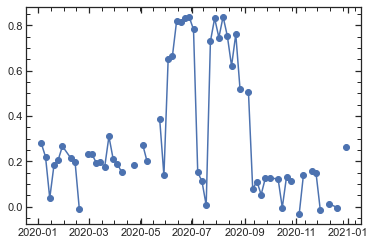

In [23]:
plt.plot(df.loc['2020'].NDVI, marker='o',linestyle='-')

In [31]:
df_daily = df.resample('D').asfreq().interpolate(method='linear'); df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2126 entries, 2017-04-24 to 2023-02-17
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   NDVI    0 non-null      float64
dtypes: float64(1)
memory usage: 33.2 KB


In [35]:
len(df_daily)/len(df)

5.395939086294416

In [16]:
opt_interp = True if input('Want to resample at a hourly frequency and interpolate values? [y/n]')=='y' else False
if opt_interp:
    df = df.resample('1H').asfreq().interpolate(method='linear').resample('D').mean()
df['Geometry'] = geometry_title
df

Want to resample at a hourly frequency and interpolate values? [y/n] n


,NDVI,Geometry
Date,,
2017-04-24 12:00:00,0.128637,budrio-half
2017-05-04 12:00:00,NaN,budrio-half
2017-05-14 12:00:00,0.106113,budrio-half
2017-05-24 12:00:00,NaN,budrio-half
2017-06-03 12:00:00,0.173408,budrio-half
...,...,...
2023-01-28 11:00:00,NaN,budrio-half
2023-02-02 11:00:00,0.102678,budrio-half
2023-02-07 11:00:00,0.104731,budrio-half


Text(0.5, 1.0, 'NDVI timeseries - 2017 to today')

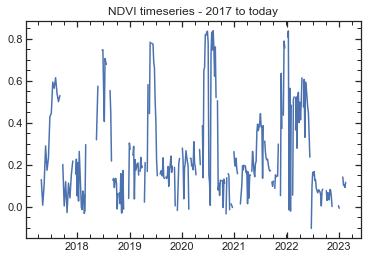

In [11]:
plt.plot(df.NDVI); plt.title('NDVI timeseries - 2017 to today')

In [12]:
save = input("Wanna save in Data directory? [y/n] ")
if save=='y':
    opt_name = input('Please provide name of file, without extension: [default: geometry-name_NDVI]')
    if opt_name=='': opt_name=geometry_title+'_NDVI'
    df.to_csv(f'..\\..\\Data\\{opt_name}.csv', sep = '\t')

Wanna save in Data directory? [y/n]  n
